In [1]:
rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

# Some constants used in the transformation
# ARE THESE CONSTANT FOR ALL FACIES ??????????????????
phi = 0.2
K_dry = 12
K0 = 36
T = 80
P_p = 300

# using Batzle-Wang
# gas gravity = 1
# water salinity = 50000
K_gas = 0.133; rho_gas = 0.336
K_water = 3.013; rho_water = 1.055


# Fluid Replacement Modelling

def frm(vp1, vs1, rho1, rho_f1, k_f1, rho_f2, k_f2, k0, phi):
    """
    INPUT
    vp1, vs1, rho1: (vector) Measured Vp, Vs and density saturated with fluid 1
    rho_f1, k_f1:   (vector) Density and bulk modulus of fluid 1 (requires Sw)
    rho_f2, k_f2:   (scalar) Density and bulk modulus of fluid 2 (rho_o, k_o, rho_g, k_g, etc)
    k0:             (scalar) mineral bulk modulus - (k_u - k_l)/2
    phi:            (vector) porosity
    
    RETURN:
    vp2, vs2, rho2, k_s2: Vp, Vs, density and bulk modulus of rock with fluid 2. 
    
    Velocities are in m/s and densities in g/cm3.
    
    USAGE:
    vp1ox, vs1ox, rho1ox, k1ox = frm(vp1*1000, vs1*1000, rho1, RHO_WATER, K_WATER, rho_o, k_o, K0, phiex1)
    """
    # convert Vp,Vs from m/s to km/s for calculation
    vp1  = vp1 / 1000.
    vs1  = vs1 / 1000.
    
    mu1  = rho1 * vs1**2.
    k_s1 = rho1 * vp1**2 - (4./3.)*mu1  # mu1 = rho1 * vs1**2
    
    # The dry rock bulk modulus
    kdry = (k_s1 * ((phi*k0)/k_f1 + 1 - phi) - k0) / ((phi*k0)/k_f1 + (k_s1/k0) - 1 - phi)
    
    # Now we can apply Gassmann to get the new values
    k_s2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_f2) + ((1-phi)/k0) - (kdry/k0**2) )
    rho2 = rho1 - phi*rho_f1 + phi*rho_f2
    mu2  = mu1
    vp2  = np.sqrt(((k_s2 + (4./3)*mu2))/rho2)
    vs2  = np.sqrt((mu2/rho2))

    # return Vp,Vs as m/s
    return vp2*1000, vs2*1000, rho2, k_s2

## The Data

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import math
import statistics
from data_loading import well2_add_features
sns.set_context("notebook")

import warnings
warnings.filterwarnings("ignore")

In [30]:
well1, well2, well3, well4, well5, well5_resist = well2_add_features()

## Monte-Carlo simulation

### Estimate kernel density (kde)

In [ ]:
# AVO_analysis_10_4-1.ipynb 
# probably need to change to include phie_k0 etc

#################################################
#### USE OF vp0, vs0, rho0, vp1, vs1, rho1 ######
####           DATA                        ######
#################################################

vp_vs_rho_phie_k0_0 = df[df.FORMATION=='Egersund']['VP'], \
                    df[df.FORMATION=='Egersund']['VS'], \
                    df[df.FORMATION=='Egersund']['DEN'], \
                    df[df.FORMATION=='Egersund']['PHIE'], \
                    df[df.FORMATION=='Egersund']['K0']

# sample from formation[1] == 'Sandnes'
vp_vs_rho_phie_k0_1 = df[df.FORMATION=='Sandnes']['VP'], \
                    df[df.FORMATION=='Sandnes']['VS'], \
                    df[df.FORMATION=='Sandnes']['DEN'], \
                    df[df.FORMATION=='Sandnes']['PHIE'], \
                    df[df.FORMATION=='Sandnes']['K0']

# sample from formation[2] == 'Bryne'
vp_vs_rho_phie_k0_2 = df[df.FORMATION=='Bryne']['VP'], \
                    df[df.FORMATION=='Bryne']['VS'], \
                    df[df.FORMATION=='Bryne']['DEN'], \
                    df[df.FORMATION=='Bryne']['PHIE'], \
                    df[df.FORMATION=='Bryne']['K0']

# sample from formation[3] == 'Triassic'
vp_vs_rho_phie_k0_3 = df[df.FORMATION=='Triassic']['VP'], \
                    df[df.FORMATION=='Triassic']['VS'], \
                    df[df.FORMATION=='Triassic']['DEN'], \
                    df[df.FORMATION=='Triassic']['PHIE'], \
                    df[df.FORMATION=='Triassic']['K0']

num_samples = 1000

kde_3d_layer0 = gaussian_kde(vp_vs_rho_phie_k0_0)
kde_3d_layer1 = gaussian_kde(vp_vs_rho_phie_k0_1)
kde_3d_layer2 = gaussian_kde(vp_vs_rho_phie_k0_2)
kde_3d_layer3 = gaussian_kde(vp_vs_rho_phie_k0_3)

kde_3d_layer0_resample = kde_3d_layer0.resample(num_samples)
kde_3d_layer1_resample = kde_3d_layer1.resample(num_samples)
kde_3d_layer2_resample = kde_3d_layer2.resample(num_samples)
kde_3d_layer3_resample = kde_3d_layer3.resample(num_samples)

#################################################
#### USE OF vp0, vs0, rho0, vp1, vs1, rho1 ######
####           SAMPLED                     ######
#################################################

vp0,vs0,rho0,phie0,k00 = kde_3d_layer0_resample
vp1,vs1,rho1,phie1,k01 = kde_3d_layer1_resample
vp2,vs2,rho2,phie2,k02 = kde_3d_layer2_resample
vp3,vs3,rho3,phie3,k03 = kde_3d_layer3_resample

vp1ox, vs1ox, rho1ox, k1ox = frm(vp1, vs1, rho1, RHO_WATER, K_WATER, RHO_GAS, K_GAS, k00, phie1)
vp2ox, vs2ox, rho2ox, k2ox = frm(vp2, vs2, rho2, RHO_WATER, K_WATER, RHO_GAS, K_GAS, k01, phie2)
vp3ox, vs3ox, rho3ox, k3ox = frm(vp3, vs3, rho3, RHO_WATER, K_WATER, RHO_GAS, K_GAS, k02, phie3)

#################################################
#### USE OF vp0, vs0, rho0, vp1, vs1, rho1 ######
####           SAMPLED                     ######
#################################################

# facies = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
r01_b, G1_b, Rtheta1_b, med1_b = r0g(vp0, vs0, rho0, vp1, vs1, rho1)
r01_o, G1_o, Rtheta1_o, med1_o = r0g(vp0, vs0, rho0, vp1ox, vs1ox, rho1ox)

r02_b, G2_b, Rtheta2_b, med2_b = r0g(vp0, vs0, rho0, vp2, vs2, rho2)
r02_o, G2_o, Rtheta2_o, med2_o = r0g(vp0, vs0, rho0, vp2ox, vs2ox, rho2ox)

r03_b, G3_b, Rtheta3_b, med3_b = r0g(vp0, vs0, rho0, vp3, vs3, rho3)
r03_o, G3_o, Rtheta3_o, med3_o = r0g(vp0, vs0, rho0, vp3ox, vs3ox, rho3ox)

# r04_b, G4_b, Rtheta4_b, med4_b = r0g(vp0, vs0, rho0, vp4, vs4, rho4)
# r04_o, G4_o, Rtheta4_o, med4_o = r0g(vp0, vs0, rho0, vp4ox/1000, vs4ox/1000, rho4ox)

# r05_b, G5_b, Rtheta5_b, med5_b = r0g(vp0, vs0, rho0, vp5, vs5, rho5)
# r05_o, G5_o, Rtheta5_o, med5_o = r0g(vp0, vs0, rho0, vp5ox/1000, vs5ox/1000, rho5ox)

In [76]:
facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]

# sample from facies[0]=='shale'
vp_vs_rho_phie_k0_0 = well2[well2.LABELS=='shale']['VP'], \
                    well2[well2.LABELS=='shale']['VS'], \
                    well2[well2.LABELS=='shale']['RHOB'], \
                    well2[well2.LABELS=='shale']['PHIE'], \
                    #well2[well2.LABELS=='shale']['K0']  # problem


# sample from facies[1] == 'sltShale'
vp_vs_rho_phie_k0_1 = well2[well2.LABELS=='sltShale']['VP'], \
                    well2[well2.LABELS=='sltShale']['VS'], \
                    well2[well2.LABELS=='sltShale']['RHOB'], \
                    well2[well2.LABELS=='sltShale']['PHIE'], \
                    well2[well2.LABELS=='sltShale']['K0']

# sample from facies[2] == 'clnSand'
vp_vs_rho_phie_k0_2 = well2[well2.LABELS=='clnSand']['VP'], \
                    well2[well2.LABELS=='clnSand']['VS'], \
                    well2[well2.LABELS=='clnSand']['RHOB'], well2[well2.LABELS=='clnSand']['K0'] \
                    #well2[well2.LABELS=='clnSand']['PHIE'], \  # problem
                    #well2[well2.LABELS=='clnSand']['K0']

# sample from facies[3] == 'sltSand1'
vp_vs_rho_phie_k0_3 = well2[well2.LABELS=='sltSand1']['VP'], \
                    well2[well2.LABELS=='sltSand1']['VS'], \
                    well2[well2.LABELS=='sltSand1']['RHOB'], well2[well2.LABELS=='sltSand1']['K0'] \
                    #well2[well2.LABELS=='sltSand1']['PHIE'], \  # problem
                    #well2[well2.LABELS=='sltSand1']['K0']

# sample from facies[4] == 'sltSand2'
vp_vs_rho_phie_k0_4 = well2[well2.LABELS=='sltSand2']['VP'], \
                    well2[well2.LABELS=='sltSand2']['VS'], \
                    well2[well2.LABELS=='sltSand2']['RHOB'], well2[well2.LABELS=='sltSand2']['K0'] \
                    #well2[well2.LABELS=='sltSand2']['PHIE'], \  # problem
                    #well2[well2.LABELS=='sltSand2']['K0']

# sample from facies[5] == 'cemSand'
vp_vs_rho_phie_k0_5 = well2[well2.LABELS=='cemSand']['VP'], \
                    well2[well2.LABELS=='cemSand']['VS'], \
                    well2[well2.LABELS=='cemSand']['RHOB'], well2[well2.LABELS=='cemSand']['K0'] \
                    #well2[well2.LABELS=='cemSand']['PHIE'], \  # problem
                    #well2[well2.LABELS=='cemSand']['K0']





<AxesSubplot:>

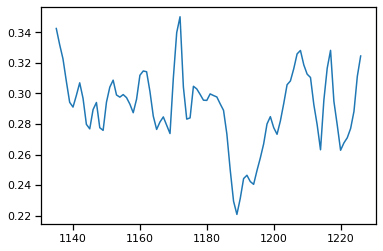

In [79]:
well2[well2.LABELS=='cemSand']['PHIE'].min(), well2[well2.LABELS=='cemSand']['PHIE'].max()
well2[well2.LABELS=='sltSand2']['PHIE'].min(), well2[well2.LABELS=='sltSand2']['PHIE'].max()
well2[well2.LABELS=='sltSand2']['PHIE'].plot()

In [77]:
kde_3d_layer0 = gaussian_kde(vp_vs_rho_phie_k0_0)  # shale
kde_3d_layer1 = gaussian_kde(vp_vs_rho_phie_k0_1)  # sltShale
kde_3d_layer2 = gaussian_kde(vp_vs_rho_phie_k0_2)  # clnSand
kde_3d_layer3 = gaussian_kde(vp_vs_rho_phie_k0_3)  # sltSand1
kde_3d_layer4 = gaussian_kde(vp_vs_rho_phie_k0_4)  # sltSand2
kde_3d_layer5 = gaussian_kde(vp_vs_rho_phie_k0_5)  # cemSand



In [ ]:
kde_3d_layer0_resample = kde_3d_layer0.resample(500)  # shale
kde_3d_layer1_resample = kde_3d_layer1.resample(500)  # sltShale
kde_3d_layer2_resample = kde_3d_layer2.resample(500)  # clnSand
kde_3d_layer3_resample = kde_3d_layer3.resample(500)  # sltSand1
kde_3d_layer4_resample = kde_3d_layer4.resample(500)  # sltSand2
kde_3d_layer5_resample = kde_3d_layer5.resample(500)  # cemSand

vp0, vs0, rho0, phie0, k00 = kde_3d_layer0_resample  # shale
vp1, vs1, rho1, phie1, k01 = kde_3d_layer1_resample  # sltShale
vp2, vs2, rho2, phie2, k02 = kde_3d_layer2_resample  # clnSand
vp3, vs3, rho3, phie3, k03 = kde_3d_layer3_resample  # sltSand1
vp4, vs4, rho4, phie4, k04 = kde_3d_layer4_resample  # sltSand2
vp5, vs5, rho5, phie5, k05 = kde_3d_layer5_resample  # cemSand

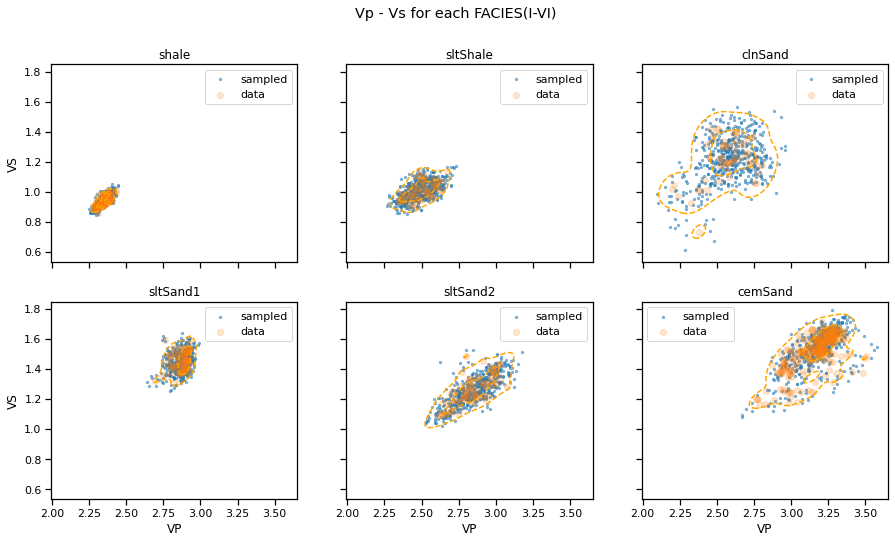

In [13]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8), sharex=True, sharey=True)
fig.suptitle('Vp - Vs for each FACIES(I-VI)')

# shale
ax1.scatter(vp0, vs0, s=5, label="sampled", alpha=0.5)
ax1.scatter(well2[well2.LABELS==facies_labels[0]]['VP'], well2[well2.LABELS==facies_labels[0]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax1, data=well2[well2.LABELS==facies_labels[0]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax1.set_xlabel("VP"); ax1.set_ylabel("VS")
ax1.set_title(facies[0])

# sltShale
ax2.scatter(vp1, vs1, s=5, label="sampled", alpha=0.5)
ax2.scatter(well2[well2.LABELS==facies_labels[1]]['VP'], well2[well2.LABELS==facies_labels[1]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax2, data=well2[well2.LABELS==facies_labels[1]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax2.set_xlabel("VP"); ax1.set_ylabel("VS")
ax2.set_title(facies[1])

# clnSand
ax3.scatter(vp2, vs2, s=5, label="sampled", alpha=0.5)
ax3.scatter(well2[well2.LABELS==facies_labels[2]]['VP'], well2[well2.LABELS==facies_labels[2]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax3, data=well2[well2.LABELS==facies_labels[2]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax3.set_xlabel("VP"); ax4.set_ylabel("VS")
ax3.set_title(facies[2])

# sltSand1
ax4.scatter(vp3, vs3, s=5, label="sampled", alpha=0.5)
ax4.scatter(well2[well2.LABELS==facies_labels[3]]['VP'], well2[well2.LABELS==facies_labels[3]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax4, data=well2[well2.LABELS==facies_labels[3]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax4.set_xlabel("VP"); ax1.set_ylabel("VS")
ax4.set_title(facies[3])

# sltSand2
ax5.scatter(vp4, vs4, s=5, label="sampled", alpha=0.5)
ax5.scatter(well2[well2.LABELS==facies_labels[4]]['VP'], well2[well2.LABELS==facies_labels[4]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax5, data=well2[well2.LABELS==facies_labels[4]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax5.set_xlabel("VP"); ax1.set_ylabel("VS")
ax5.set_title(facies[4])

# cemSand
ax6.scatter(vp5, vs5, s=5, label="sampled", alpha=0.5)
ax6.scatter(well2[well2.LABELS==facies_labels[5]]['VP'], well2[well2.LABELS==facies_labels[5]]['VS'], label="data", alpha=0.2)
sns.kdeplot(ax=ax6, data=well2[well2.LABELS==facies_labels[5]], x='VP', y='VS', color="orange", linestyles="--", levels=3)
ax6.set_xlabel("VP"); ax4.set_ylabel("VS")
ax6.set_title(facies[5])

#plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()

### Gaussian sampled brine and sampled oil case

### Use sampled brine and transform to oil case

In [14]:
# IS K0 CONSTANT FOR EVERY FACIES ?????????
# calculate K0 for each sample through vrh() # Voigt-Reuss-Hill average mineral mixtures
""" 
def frm(vp1, vs1, rho1, rho_f1, k_f1, rho_f2, k_f2, k0, phi):

    INPUT
    vp1, vs1, rho1: (vector) Measured Vp, Vs and density saturated with fluid 1
    rho_f1, k_f1:   (vector) Density and bulk modulus of fluid 1 (requires Sw)
    rho_f2, k_f2:   (scalar) Density and bulk modulus of fluid 2 (rho_o, k_o, rho_g, k_g, etc)
    k0:             (scalar) mineral bulk modulus - (k_u - k_l)/2
    phi:            (vector) porosity
    
    RETURN 
    vp2, vs2, rho2, k_s2: Vp, Vs, density and bulk modulus of rock with fluid 2. 
    
    Velocities are in m/s and densities in g/cm3.
    """

# i think K0 is a fixed value of 36 - needs changing to vp_vs_rho_phie_k0_0 etc ...
vp1ox, vs1ox, rho1ox, k1ox = frm(vp1*1000, vs1*1000, rho1, rho_water, K_water, rho_o, k_o, K0, phiex1)  # sltShale
vp2ox, vs2ox, rho2ox, k2ox = frm(vp2*1000, vs2*1000, rho2, rho_water, K_water, rho_o, k_o, K0, phiex2)  # clnSand
vp3ox, vs3ox, rho3ox, k3ox = frm(vp3*1000, vs3*1000, rho3, rho_water, K_water, rho_o, k_o, K0, phiex3)  # sltSand1
vp4ox, vs4ox, rho4ox, k4ox = frm(vp4*1000, vs4*1000, rho4, rho_water, K_water, rho_o, k_o, K0, phiex4)  # sltSand2
vp5ox, vs5ox, rho5ox, k5ox = frm(vp5*1000, vs5*1000, rho5, rho_water, K_water, rho_o, k_o, K0, phiex5)  # cemSand

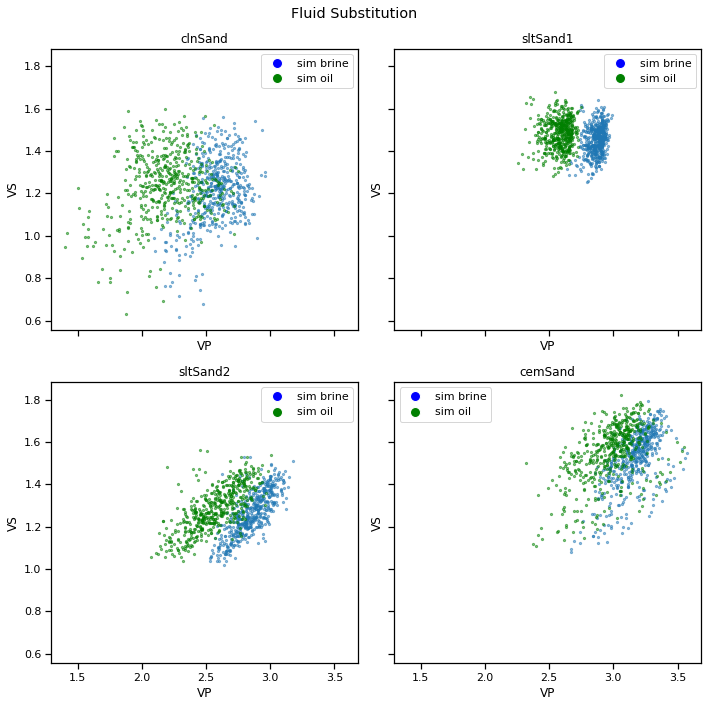

In [15]:
from matplotlib.lines import Line2D

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle('Fluid Substitution')

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='sim brine'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='sim oil')]


# ax1.scatter(vp1, vs1, alpha=0.5, s=5, label='simulated brine')
# ax1.scatter(vp1ox/1000, vs1ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
# ax1.set_xlabel("VP"); ax1.set_ylabel("VS"); ax1.set_title(facies[1])

# clnSand
ax1.scatter(vp2, vs2, alpha=0.5, s=5, label='simulated brine')
ax1.scatter(vp2ox/1000, vs2ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax1.set_xlabel("VP"); ax1.set_ylabel("VS"); ax1.set_title(facies[2])

# sltSand1
ax2.scatter(vp3, vs3, alpha=0.5, s=5, label='simulated brine')
ax2.scatter(vp3ox/1000, vs3ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax2.set_xlabel("VP"); ax2.set_ylabel("VS"); ax2.set_title(facies[3])

# sltSand2
ax3.scatter(vp4, vs4, alpha=0.5, s=5, label='simulated brine')
ax3.scatter(vp4ox/1000, vs4ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax3.set_xlabel("VP"); ax3.set_ylabel("VS"); ax3.set_title(facies[4])

# cemSand
ax4.scatter(vp5, vs5, alpha=0.5, s=5, label='simulated brine')
ax4.scatter(vp5ox/1000, vs5ox/1000, alpha=0.5, s=5, label='simulated oil', color='green')
ax4.set_xlabel("VP"); ax4.set_ylabel("VS"); ax4.set_title(facies[5])

plt.tight_layout()
for ax in fig.get_axes():
    ax.legend(handles=custom_lines)


# plt.savefig("./images/vp_vs_sim_fl_sub.png")


$$
R(\theta) \approx R(0) + Gsin^2\theta
$$

$R(0) = \frac{1}{2} \bigg(\frac{\Delta V_P}{V_P} + \frac{\Delta \rho}{\rho} \bigg)$

$G = \frac{1}{2} \frac{\Delta V_P}{V_P} - 2 \frac{V_S^2}{V_P^2} \bigg(\frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_S}{V_S} \bigg)$

In [16]:
def r0g_model(vp1, vs1, rho1, vp2, vs2, rho2):
    
    R0 = []
    G = []
    R_theta = []

    for i in range(len(vp1)):

        delta_rho = rho2[i] - rho1[i]
        delta_vp = vp2[i] - vp1[i]
        delta_vs = vs2[i] - vs1[i]

        vp = (vp2[i] + vp1[i]) / 2
        vs = (vs2[i] + vs1[i]) / 2
        rho = (rho2[i] + rho1[i]) / 2

        R0_temp = 1/2*((delta_vp / vp) + (delta_rho / rho))
        R0.append(R0_temp)

        G_temp = 1/2 * (delta_vp / vp) - 2 * vs**2/vp**2 * ((delta_rho / rho) + (2*delta_vs / vs))
        G.append(G_temp)

        R_theta_i = []
        for theta in range(41):
            R_theta_i.append(R0_temp + G_temp*(np.sin(math.radians(theta))**2))
        R_theta.append([R_theta_i])        

    median = []

    for j in range(41):
        angle = []
        for k in range(len(vp2)):
            angle.append(R_theta[k][0][j])
        median.append(statistics.median(angle))
        
    return R0, G, R_theta, median

In [22]:
# facies = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]

# take two samples of shale to plot against itself
kde_3d_layer0_resample = kde_3d_layer0.resample(500)  # shale
vp0a, vs0a, rho0a = kde_3d_layer0_resample  # shale
kde_3d_layer0_resample = kde_3d_layer0.resample(500)  # shale
vp0b, vs0b, rho0b = kde_3d_layer0_resample  # shale

# shale-shale
# r00, G00, Rtheta00, med00 = r0g_model(vp0, vs0, rho0, vp0, vs0, rho0)
r00, G00, Rtheta00, med00 = r0g_model(vp0a, vs0a, rho0a, vp0b, vs0b, rho0b)

# shale-sltShale
r01_b, G1_b, Rtheta1_b, med1_b = r0g_model(vp0, vs0, rho0, vp1, vs1, rho1)
# r01_o, G1_o, Rtheta1_o, med1_o = r0g_model(vp0, vs0, rho0, vp1ox/1000, vs1ox/1000, rho1ox)

# shale-clnSand
r02_b, G2_b, Rtheta2_b, med2_b = r0g_model(vp0, vs0, rho0, vp2, vs2, rho2)
r02_o, G2_o, Rtheta2_o, med2_o = r0g_model(vp0, vs0, rho0, vp2ox/1000, vs2ox/1000, rho2ox)

# shale-sltSand1
r03_b, G3_b, Rtheta3_b, med3_b = r0g_model(vp0, vs0, rho0, vp3, vs3, rho3)
r03_o, G3_o, Rtheta3_o, med3_o = r0g_model(vp0, vs0, rho0, vp3ox/1000, vs3ox/1000, rho3ox)

# shale-sltSand2
r04_b, G4_b, Rtheta4_b, med4_b = r0g_model(vp0, vs0, rho0, vp4, vs4, rho4)
r04_o, G4_o, Rtheta4_o, med4_o = r0g_model(vp0, vs0, rho0, vp4ox/1000, vs4ox/1000, rho4ox)

# shale-cemSand
r05_b, G5_b, Rtheta5_b, med5_b = r0g_model(vp0, vs0, rho0, vp5, vs5, rho5)
r05_o, G5_o, Rtheta5_o, med5_o = r0g_model(vp0, vs0, rho0, vp5ox/1000, vs5ox/1000, rho5ox)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


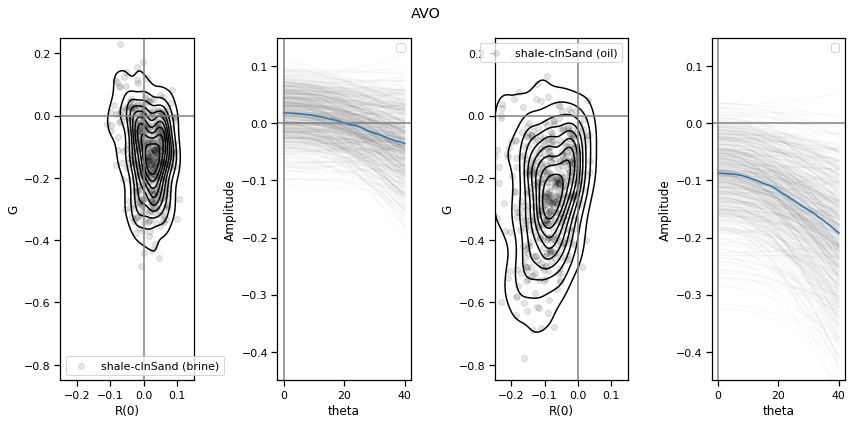

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,6))
fig.suptitle('AVO')

ax1.scatter(r02_b, G2_b, label="shale-clnSand (brine)", alpha=0.1, color='k')  # ? Facies IIa
sns.kdeplot(ax=ax1, x=r02_b, y=G2_b, color="k", linestyles="-")
ax1.set_xlabel("R(0)"); ax1.set_ylabel("G")
ax1.set_xlim(-0.25, 0.15); ax1.set_ylim(-0.85, 0.25)

for i in range(len(vp2)):
    ax2.plot(Rtheta2_b[i][0], alpha=0.02, color='k')
ax2.plot(med2_b)
ax2.set_xlabel("theta"); ax2.set_ylabel("Amplitude")
ax2.set_ylim(-0.45, 0.15)

ax3.scatter(r02_o, G2_o, label="shale-clnSand (oil)", alpha=0.1, color='k')  # ? Facies IIa
sns.kdeplot(ax=ax3, x=r02_o, y=G2_o, color="k", linestyles="-")
ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")
ax3.set_xlim(-0.25, 0.15); ax3.set_ylim(-0.85, 0.25)

for i in range(len(vp2)):
    ax4.plot(Rtheta2_o[i][0], alpha=0.02, color='k')
ax4.plot(med2_o)
ax4.set_xlabel("theta"); ax4.set_ylabel("Amplitude")
ax4.set_ylim(-0.45, 0.15)

for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    ax.axhline(0, color='gray')
    ax.axvline(0, color='gray')
    
plt.tight_layout()

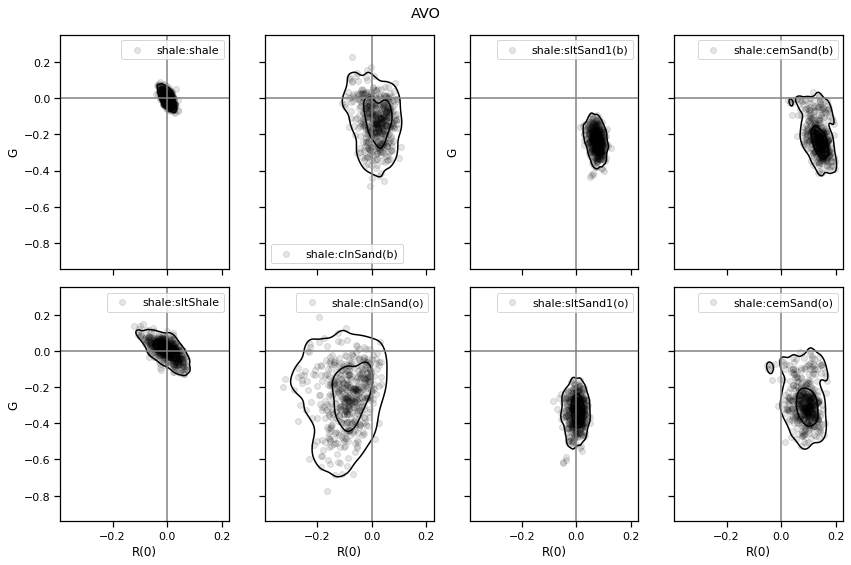

In [19]:
# shale-shale:            r00,   G00,  Rtheta00,  med00 =  r0g_model(vp0, vs0, rho0, vp0, vs0, rho0)
# shale-sltShale:         r01_b, G1_b, Rtheta1_b, med1_b = r0g_model(vp0, vs0, rho0, vp1, vs1, rho1)
# shale-clnSand (brine):  r02_b, G2_b, Rtheta2_b, med2_b = r0g_model(vp0, vs0, rho0, vp2, vs2, rho2)
# shale-clnSand (oil):    r02_o, G2_o, Rtheta2_o, med2_o = r0g_model(vp0, vs0, rho0, vp2ox/1000, vs2ox/1000, rho2ox)
# shale-sltSand1 (brine): r03_b, G3_b, Rtheta3_b, med3_b = r0g_model(vp0, vs0, rho0, vp3, vs3, rho3)
# shale-sltSand1 (oil):   r03_o, G3_o, Rtheta3_o, med3_o = r0g_model(vp0, vs0, rho0, vp3ox/1000, vs3ox/1000, rho3ox)
# shale-cemSand (brine):  r05_b, G5_b, Rtheta5_b, med5_b = r0g_model(vp0, vs0, rho0, vp5, vs5, rho5)
# shale-cemSand (oil):    r05_o, G5_o, Rtheta5_o, med5_o = r0g_model(vp0, vs0, rho0, vp5ox/1000, vs5ox/1000, rho5ox)

fig, ((ax1, ax2, ax3, ax4),( ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('AVO')

# shale:shale
ax1.scatter(r00, G00, label="shale:shale", alpha=0.1, color='k')
sns.kdeplot(ax=ax1, x=r00, y=G00, color="k", linestyles="-", levels=3)
ax1.set_xlabel("R(0)"); ax1.set_ylabel("G")

# shale:sltShale
ax5.scatter(r01_b, G1_b, label="shale:sltShale", alpha=0.1, color='k')
sns.kdeplot(ax=ax5, x=r01_b, y=G1_b, color="k", linestyles="-", levels=3)
ax5.set_xlabel("R(0)"); ax5.set_ylabel("G")

# shale:clnSand (brine)
ax2.scatter(r02_b, G2_b, label="shale:clnSand(b)", alpha=0.1, color='k')
sns.kdeplot(ax=ax2, x=r02_b, y=G2_b, color="k", linestyles="-", levels=3)
ax2.set_xlabel("R(0)"); ax3.set_ylabel("G")

# shale:clnSand (oil)
ax6.scatter(r02_o, G2_o, label="shale:clnSand(o)", alpha=0.1, color='k')
sns.kdeplot(ax=ax6, x=r02_o, y=G2_o, color="k", linestyles="-", levels=3)
ax6.set_xlabel("R(0)"); ax6.set_ylabel("G")

# shale:sltSand1 (brine)
ax3.scatter(r03_b, G3_b, label="shale:sltSand1(b)", alpha=0.1, color='k')
sns.kdeplot(ax=ax3, x=r03_b, y=G3_b, color="k", linestyles="-", levels=3)
ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")

# shale:sltSand1 (oil)
ax7.scatter(r03_o, G3_o, label="shale:sltSand1(o)", alpha=0.1, color='k')
sns.kdeplot(ax=ax7, x=r03_o, y=G3_o, color="k", linestyles="-", levels=3)
ax7.set_xlabel("R(0)"); ax7.set_ylabel("G")

# shale:cemSand (brine)
ax4.scatter(r05_b, G5_b, label="shale:cemSand(b)", alpha=0.1, color='k')
sns.kdeplot(ax=ax4, x=r05_b, y=G5_b, color="k", linestyles="-", levels=3)
ax4.set_xlabel("R(0)"); ax4.set_ylabel("G")

# shale:cemSand (oil)
ax8.scatter(r05_o, G5_o, label="shale:cemSand(o)", alpha=0.1, color='k')
sns.kdeplot(ax=ax8, x=r05_o, y=G5_o, color="k", linestyles="-", levels=3)
ax8.set_xlabel("R(0)"); ax8.set_ylabel("G")

# ax4.scatter(r04_b, G4_b, label="Facies IV - brine", alpha=0.1, color='k')
# sns.kdeplot(ax=ax4, x=r04_b, y=G4_b, color="k", linestyles="-", levels=3)
# ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")

# ax9.scatter(r04_o, G4_o, label="Facies IV - oil", alpha=0.1, color='k')
# sns.kdeplot(ax=ax9, x=r04_o, y=G4_o, color="k", linestyles="-", levels=3)
# ax9.set_xlabel("R(0)"); ax3.set_ylabel("G")

for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    
    ax.axvline(0, color='gray')
    ax.axhline(0, color='gray')
    
plt.tight_layout()

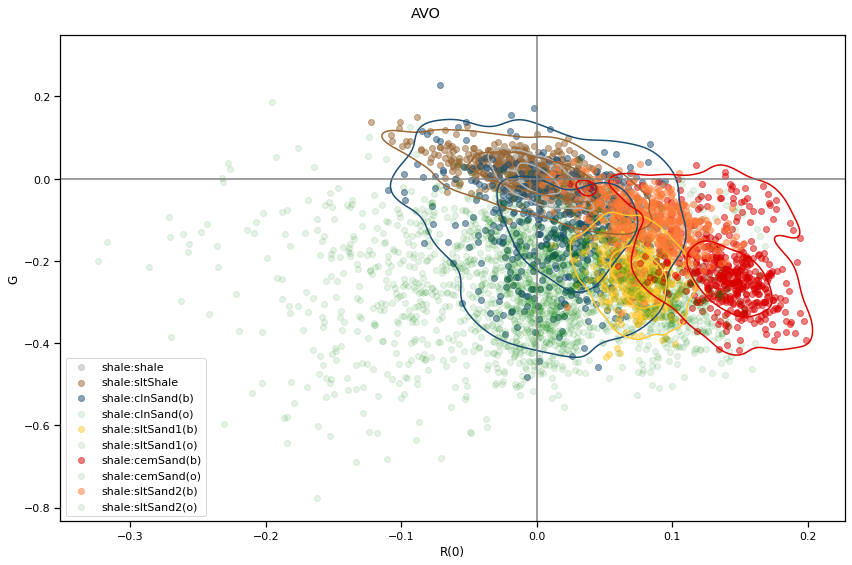

In [23]:
#
ccc = ['#B3B3B3', '#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF']

fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('AVO')

# shale:shale
ax.scatter(r00, G00, label="shale:shale", alpha=0.5, color=ccc[0])

# shale:sltShale
ax.scatter(r01_b, G1_b, label="shale:sltShale", alpha=0.5, color=ccc[1])

# shale:clnSand (brine)
ax.scatter(r02_b, G2_b, label="shale:clnSand(b)", alpha=0.5, color=ccc[2])

# shale:clnSand (oil)
ax.scatter(r02_o, G2_o, label="shale:clnSand(o)", alpha=0.1, color='g')

# shale:sltSand1 (brine)
ax.scatter(r03_b, G3_b, label="shale:sltSand1(b)", alpha=0.5, color=ccc[3])

# shale:sltSand1 (oil)
ax.scatter(r03_o, G3_o, label="shale:sltSand1(o)", alpha=0.1, color='g')

# shale:cemSand (brine)
ax.scatter(r05_b, G5_b, label="shale:cemSand(b)", alpha=0.5, color=ccc[5])

# shale:cemSand (oil)
ax.scatter(r05_o, G5_o, label="shale:cemSand(o)", alpha=0.1, color='g')

# shale:sltSand2 (brine)
ax.scatter(r04_b, G4_b, label="shale:sltSand2(b)", alpha=0.5, color=ccc[4])

# shale:sltSand2 (oil)
ax.scatter(r04_o, G4_o, label="shale:sltSand2(o)", alpha=0.1, color='g')

# shale:shale
sns.kdeplot(ax=ax, x=r00, y=G00, color=ccc[0], linestyles="-", levels=3)
# shale:sltShale
sns.kdeplot(ax=ax, x=r01_b, y=G1_b, color=ccc[1], linestyles="-", levels=3)
# shale:clnSand (brine)
sns.kdeplot(ax=ax, x=r02_b, y=G2_b, color=ccc[2], linestyles="-", levels=3)
# shale:clnSand (oil)
#sns.kdeplot(ax=ax, x=r02_o, y=G2_o, color="g", linestyles="-", levels=3)
# shale:sltSand1 (brine)
sns.kdeplot(ax=ax, x=r03_b, y=G3_b, color=ccc[3], linestyles="-", levels=3)
# shale:sltSand1 (oil)
#sns.kdeplot(ax=ax, x=r03_o, y=G3_o, color="g", linestyles="-", levels=3)
# shale:cemSand (brine)
sns.kdeplot(ax=ax, x=r05_b, y=G5_b, color=ccc[5], linestyles="-", levels=3)
# shale:cemSand (oil)
#sns.kdeplot(ax=ax, x=r05_o, y=G5_o, color="g", linestyles="-", levels=3)
#sns.kdeplot(ax=ax, x=r04_b, y=G4_b, color=ccc[4], linestyles="-", levels=3)
#sns.kdeplot(ax=ax, x=r04_o, y=G4_o, color="g", linestyles="-", levels=3)


ax.set_xlabel("R(0)"); ax.set_ylabel("G")
ax.axvline(0, color='gray')
ax.axhline(0, color='gray')
ax.legend()
    
plt.tight_layout()






In [15]:
#!pip install kalepy

In [16]:
%reload_ext autoreload
%autoreload 2
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 12})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.rc('figure', figsize=[8, 4])
plt.rc('axes', grid=True)
plt.rcParams.update({'grid.alpha': 0.25})

import kalepy as kale

reload(kale.kde)
reload(kale.kernels)
reload(kale.utils)
reload(kale.plot)
reload(kale)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from kalepy.plot import nbshow



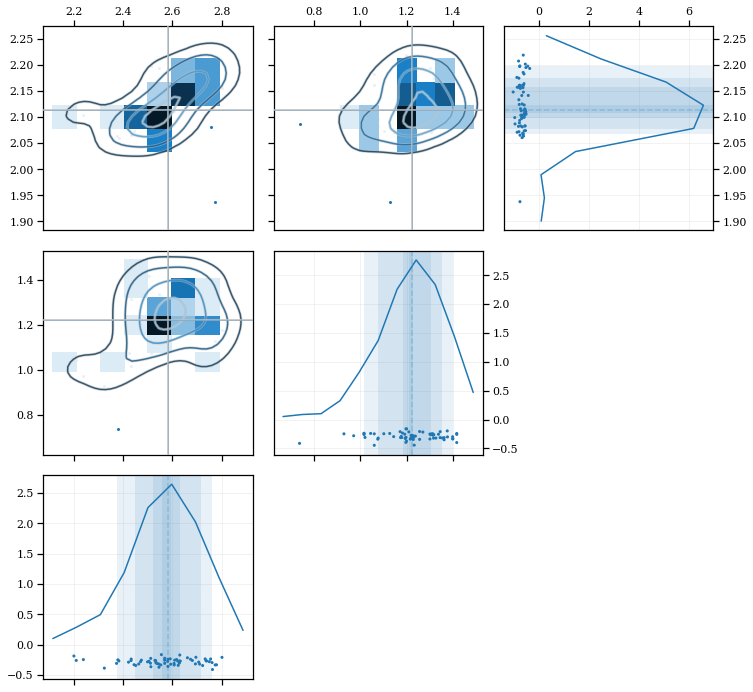

In [17]:
kde = kale.KDE(vp2_vs2_rho2)
kale.corner(kde)

nbshow()

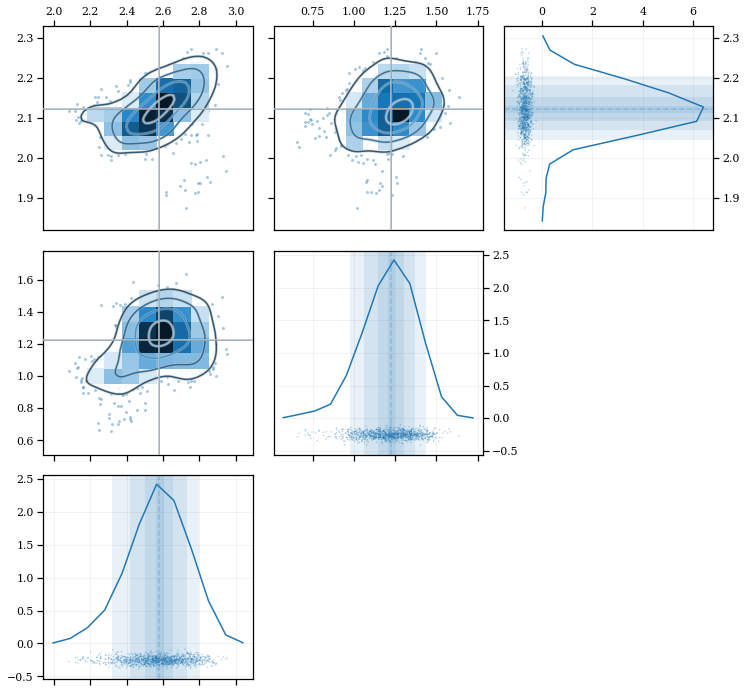

In [18]:
samples_1000 = kde.resample(1000)
#print(len(samples[0]))
kale.corner(samples_1000)
nbshow()